In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import batman
import lightkurve
from lightkurve import KeplerTargetPixelFile
from lightkurve.lightcurve import LightCurve

The model I make will be based on the following free parameters: period, Rp, Rs, and stellar i mag

In [12]:
def BATMAN_MODEL(Baseline, Rp, t0=0, t = None):
    
    # Rp in units of R_earth
    # period in hours
    period = 240.0
    Rs = 0.3
    Radius = Rp*(1.0/100.0)/Rs
    a = (Rs*(period/24.0/365.0)**2.0)**(1.0/3.0) #in au
    a = a*215.0 # AU to R_sun conversion
    
    params = batman.TransitParams()
    params.t0 = t0                      #time of inferior conjunction
    params.per = period               #period in hours
    params.rp = Radius         #planet radius (in units of stellar radii)
    params.a = (a/Rs)                       #semi-major axis (in units of stellar radii)
    params.inc = 90.                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1956, 0.3700]          #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model
        
    m = batman.TransitModel(params, t)    #initializes model
    
    flux = m.light_curve(params)*Baseline       #calculates light curve
    
    return flux

I need to specify my magnitude-noise model, based on curve fitting I performed with magnitude and SNR estimates from the LCO exptime calculator.

In [3]:
def poly_model(mag):
    SNR = 57.31794766*mag**2.0 - 1909.2116312*mag + 15991.60620416
    return 1.0/SNR

I need to simulate fake data in order to test the MCMC:

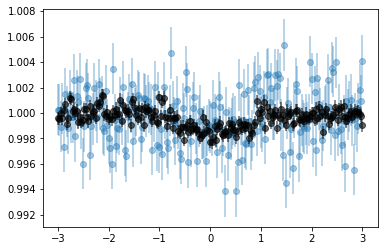

In [21]:
start_hr = -3.0
stop_hr = 3.0
length = np.int((stop_hr-start_hr)*60*60/102) #For LCO this is a 60s exp and 42s readout, so the # of exposures is limited

times = np.linspace(start_hr,stop_hr,length)
data = BATMAN_MODEL(Baseline = 1.0, Rp = 1.0, t0=0, t = times)

#LCO 1M Noise
noise = np.sqrt(3)*poly_model(13.0)
scatter = np.random.normal(0,noise,len(data))
sim = data + scatter
errors = np.linspace(noise,noise,len(data))

#LCO MusCAT Noise
noise_muscat = np.sqrt(3)*poly_model(13.0)/4
scatter_muscat = np.random.normal(0,noise_muscat,len(data))
sim_muscat = data + scatter_muscat
errors_muscat = np.linspace(noise_muscat,noise_muscat,len(data))

#noise = 0.00321158 #This is for TESS noise

plt.figure()
plt.errorbar(times,sim,yerr=errors,fmt='o',alpha=0.4)
plt.errorbar(times,sim_muscat,yerr=errors_muscat,fmt='o',alpha=0.6,c='k',zorder=100)
plt.savefig('noise_model.pdf')
plt.show()

In [5]:
print(noise)

0.0012975610664824862


Define the log probability, using Gaussian priors

In [6]:
def lnprob(parameters, plot=False,extra_mods=False,Title='',Rp_best=0,Rp_diff=0,t0_best=0,t0_diff=0):
        
    # pull out some model parameters
    Baseline, Rp, t0 = parameters
    
    flux = BATMAN_MODEL(Baseline, Rp, t0, t = times)
    
    if plot:
        plt.errorbar(times,sim,yerr=errors,fmt='o',alpha = 0.5,label='Simulated Data')
        plt.plot(times,flux,label='MCMC Model',color='k',zorder=100)
        plt.xlabel('Hours from Mid-Transit')
        plt.ylabel('Flux')
        plt.text(1,0.996,'Rp={}$\pm${}'.format(Rp_best,Rp_diff)+' R$_{\otimes}$')
        plt.text(1,0.995,'t$_0$={}$\pm${}'.format(t0_best,t0_diff)+' hours')
        plt.suptitle(Title)
        
        if extra_mods:
            y1 = BATMAN_MODEL(Baseline, Rp, t0+t0_diff, t = times)
            y2 = BATMAN_MODEL(Baseline, Rp, t0-t0_diff, t = times)
            plt.fill_between(times,y1,y2,label='1-$\sigma$ Models',alpha=0.5,color='red',zorder=100)
            y1 = BATMAN_MODEL(Baseline, Rp+Rp_diff, t0, t = times)
            y2 = BATMAN_MODEL(Baseline, Rp-Rp_diff, t0, t = times)
            plt.fill_between(times,y1,y2,alpha=0.5,color='red',zorder=100)
        plt.legend(frameon=False)    
        plt.savefig('LightCurve_Simulation.pdf')   
        plt.show()
    
    # this is a Gaussian likelihood, for independent data points
    
    if (0.0 < Baseline) and (0.0 <= Rp) and (-3.0 < t0 < 3.0 ):
        chisq = np.sum((sim - flux)**2/(errors)**2)
        lnp = np.sum(1/np.sqrt(2*np.pi*(errors))) - 0.5*chisq
    
        return lnp
    
    return -np.inf

Test that the lnprob, with a given set of (true) parameters, returns the expected model.

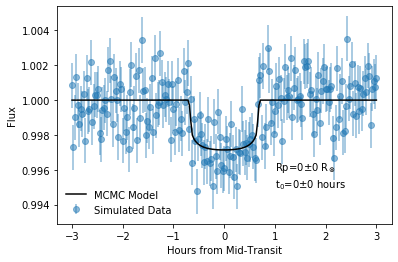

2222.2605163709895


In [7]:
params = [1.0,1.0,0.0]
a = lnprob(params,plot=True)
print(a)

In [430]:
# intialize some walkers
ndim, nwalkers, nsteps = 3, 100, 5000

# these are initial parameters
Base_initial = np.random.uniform(0.5, 1.5, nwalkers)
Rp_initial = np.random.uniform(1, 5, nwalkers)
t0_initial = np.random.uniform(-0.05, 0.05, nwalkers)

p0 = np.transpose([Base_initial, Rp_initial, t0_initial])

In [431]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
result = sampler.run_mcmc(p0, nsteps)

In [432]:
def plot_chain(start=0, stop=nsteps):
    '''Plot the chain, in a couple different ways.'''

    Base, Rp, t0 = sampler.chain.T
    Base_trimmed, Rp_trimmed, t0_trimmed = sampler.chain.T[:, start:stop, :]

    plt.figure(figsize=(14,14))
    gs = plt.matplotlib.gridspec.GridSpec(4,2, hspace=0.6)
    
    #Walker Plots
    ax_Base = plt.subplot(gs[0,0])
    ax_Base.plot(Base.flatten()[::nwalkers],color='black',alpha=0.5); 
    ax_Base.axvspan(start, stop, zorder=-1,alpha=0.3); 
    ax_Base.set_ylabel('Baseline Flux')
    
    ax_Rp = plt.subplot(gs[0,1], sharex=ax_Base)
    ax_Rp.plot(Rp.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_Rp.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_Rp.set_ylabel('Rp')
    
    ax_t0 = plt.subplot(gs[1,0], sharex=ax_Base)
    ax_t0.plot(t0.flatten()[::nwalkers],color='black',alpha=0.5)
    ax_t0.axvspan(start, stop, zorder=-1,alpha=0.3)
    ax_t0.set_ylabel('Mid-Transit Time (hr)')
    
    #Histograms
    ax_Basehist = plt.subplot(gs[1,1])
    ax_Basehist.hist(Base.flatten(),color='black',bins=60)
    ax_Basehist.axvline(1.0,zorder=100,color='purple')
    ax_Basehist.set_xlabel('Baseline')
    
    ax_Rphist = plt.subplot(gs[2,0])
    ax_Rphist.hist(Rp.flatten(),color='black',bins=60)
    ax_Rphist.axvline(1,zorder=100,color='purple')
    ax_Rphist.set_xlabel('Rp')
    
    ax_t0hist = plt.subplot(gs[2,1])
    ax_t0hist.hist(t0.flatten(),color='black',bins=60)
    ax_t0hist.axvline(0,zorder=100,color='purple')
    ax_t0hist.set_xlabel('Mid-Transit')
    
    #Scatter Plots
    ax_both = plt.subplot(gs[3,0])
    ax_both.scatter(Base_trimmed, Rp_trimmed, s=5, alpha=0.1)
    ax_both.set_title('{} to {}'.format(start, stop))
    ax_both.set_xlabel('Baseline')
    ax_both.set_ylabel('Rp')
    
    ax_both = plt.subplot(gs[3,1])
    ax_both.scatter(t0_trimmed, Rp_trimmed, s=5, alpha=0.1)
    ax_both.set_title('{} to {}'.format(start, stop))
    ax_both.set_xlabel('Mid-Transit')
    ax_both.set_ylabel('Rp')
    
    plt.savefig('MCMC_Simulated_Data.png')

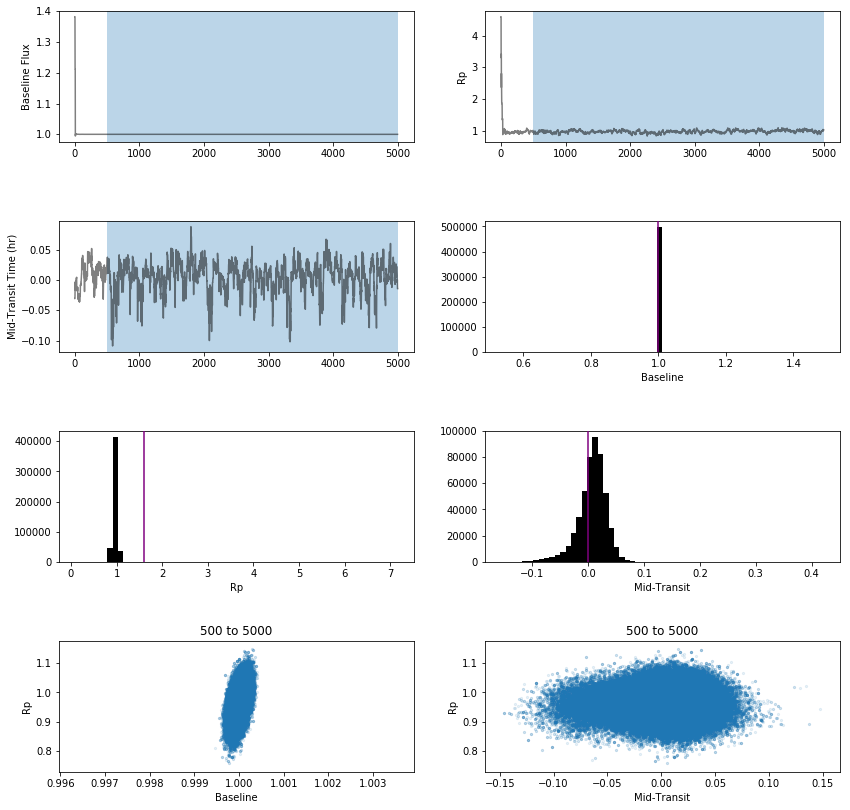

In [433]:
plot_chain(500,5000)

In [434]:
Base, Rp, t0 = sampler.chain.T

sig1_Rp = np.percentile(Rp, [16., 50., 84.])
print(sig1_Rp)
sig1_Base = np.percentile(Base, [16., 50., 84.])
print(sig1_Base)
sig1_t0 = np.percentile(t0, [16., 50., 84.])
print(sig1_t0)

[0.92629816 0.96942846 1.01135493]
[0.99988983 0.99999297 1.00009549]
[-0.0146331   0.01015457  0.02925185]


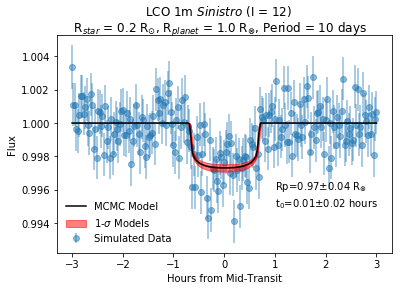

In [435]:
params = [sig1_Base[1],sig1_Rp[1],sig1_t0[1]]
a = lnprob(params,plot=True,extra_mods=True,
           Title='LCO 1m $\t{Sinistro}$ (I = 12)\n R$_{star}$ = 0.2 R$_{\odot}$, R$_{planet}$ = 1.0 R$_{\otimes}$, Period = 10 days',
          Rp_best=0.97,Rp_diff=0.04,
          t0_best=0.01,t0_diff=0.02)